# Section 4 - Deep Learning Project

#### 주제 : 자율주행

# 사전 설명

* 선정 이유 
  * 전기자동차에 관심이 많아 이후에 이와 관련된 SW 개발 직무에서 일을 배우고 싶습니다.
  * 지금 어느정도 배우고 프로젝트를 진행한다면 지원할 때나 입사 후에도 도움이 될 것으로 생각하기 때문에 자율주행을 주제로 선정하게 되었습니다.

* Data Collection
  * Udacity(open course를 제공하는 사이트) 에서 제공하는 Self-Driving Car Simulation 프로그램을 통해 저의 주행 패턴을 그림으로 받아올 수 있습니다.

* Evaluation
  * Test Simulation 에서 자율주행이 잘 이루어지는지 확인해 보겠습니다.



# 사전 작업

In [1]:
!git clone https://github.com/taeyoonnoh/Track.git

Cloning into 'Track'...
remote: Enumerating objects: 62575, done.
remote: Counting objects: 100% (7275/7275), done.
remote: Compressing objects: 100% (7274/7274), done.
remote: Total 62575 (delta 0), reused 7272 (delta 0), pack-reused 55300
Receiving objects: 100% (62575/62575), 820.07 MiB | 35.17 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (29797/29797), done.


In [2]:
#%cd /content/Track
#!git pull

In [3]:
#%cd /content
#!ls Track

In [4]:
#!pip3 install imgaug

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
import os
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

# 데이터 불러오기

In [6]:
datadir = 'Track/New_Tracks'
columns = ['center','left','right','steering','throttle','reverse','speed']
df = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option("display.max_colwidth",-1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\lge\Desktop\autonomous\New_Tracks\IMG\center_2021_04_27_20_46_33_087.jpg  ...  0.000003
1  C:\Users\lge\Desktop\autonomous\New_Tracks\IMG\center_2021_04_27_20_46_33_159.jpg  ...  0.000008
2  C:\Users\lge\Desktop\autonomous\New_Tracks\IMG\center_2021_04_27_20_46_33_231.jpg  ...  0.000003
3  C:\Users\lge\Desktop\autonomous\New_Tracks\IMG\center_2021_04_27_20_46_33_306.jpg  ...  0.000011
4  C:\Users\lge\Desktop\autonomous\New_Tracks\IMG\center_2021_04_27_20_46_33_376.jpg  ...  0.000011

[5 rows x 7 columns]

# 데이터 전처리

In [7]:
def path_leaf(path) :
  head,tail = ntpath.split(path)
  return tail
df['center'] = df['center'].apply(path_leaf)
df['left'] = df['left'].apply(path_leaf)
df['right'] = df['right'].apply(path_leaf)

# 확인용
df.head()

center  ...     speed
0  center_2021_04_27_20_46_33_087.jpg  ...  0.000003
1  center_2021_04_27_20_46_33_159.jpg  ...  0.000008
2  center_2021_04_27_20_46_33_231.jpg  ...  0.000003
3  center_2021_04_27_20_46_33_306.jpg  ...  0.000011
4  center_2021_04_27_20_46_33_376.jpg  ...  0.000011

[5 rows x 7 columns]

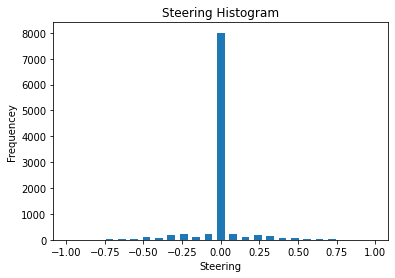

In [8]:
# 바퀴 앵글 시각화

num_bins = 25
hist, bins = np.histogram(df['steering'],num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)
plt.xlabel("Steering")
plt.ylabel("Frequencey")
plt.title("Steering Histogram")
plt.show()

* Gaussian 분포를 띕니다.
* 이 상태에서 모델에 학습시킨다면 코너링을 해야되는 부분에서도 직진을 하는 문제가 발생할 수 있습니다.

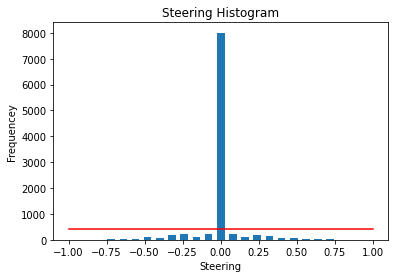

In [9]:
 # 바퀴 앵글
 
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['steering'],num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(df['steering']),np.max(df['steering'])),(samples_per_bin,samples_per_bin),color='r')
plt.xlabel("Steering")
plt.ylabel("Frequencey")
plt.title("Steering Histogram")

plt.show()

total data: 9889
removed 7607
remaining: 2282


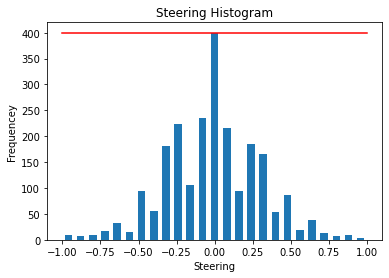

In [11]:
# Balancing Data

print("total data:", len(df))
remove_list = []

for j in range(num_bins) :
  list_ = []
  for i in range(len(df['steering'])) :
    if (df['steering'].iloc[i] >= bins[j]) and (df['steering'].iloc[i] <= bins[j+1]): 
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print("removed",len(remove_list))
df.drop(df.index[remove_list],inplace=True)
print("remaining:",len(df))

hist,_ = np.histogram(df['steering'],(num_bins))
plt.bar(center,hist,width=0.05)
plt.plot((np.min(df['steering']),np.max(df['steering'])),(samples_per_bin,samples_per_bin),color='r')
plt.xlabel("Steering")
plt.ylabel("Frequencey")
plt.title("Steering Histogram")

plt.show()

* 데이터 분포의 밸런스를 어느정도 맞춰 주었습니다.

# Train / Test Split

In [12]:
# train / test

def load_img_steering(datadir,df) :
  image_path = []
  steering = []
  for i in range(len(df)) :
    indexed_data = df.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths,steerings

datadir = 'Track/New_Tracks'
image_paths,steerings = load_img_steering(datadir + '/IMG',df)

In [13]:
X_train,X_validation,y_train,y_validation = train_test_split(image_paths,steerings,test_size=0.2,random_state=42)

X_train.shape,y_train.shape,X_validation.shape,y_validation.shape

((1825,), (1825,), (457,), (457,))

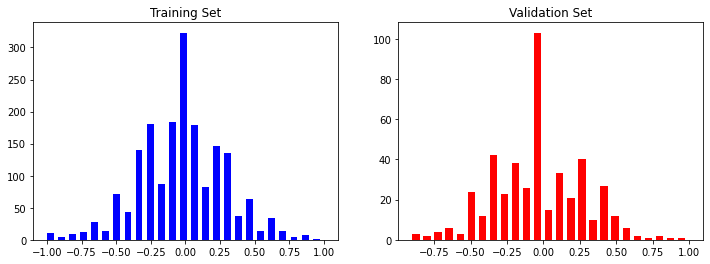

In [14]:
# Training / Validation Set Visualization

fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title("Training Set")
axes[1].hist(y_validation,bins=num_bins,width=0.05,color='red')
axes[1].set_title("Validation Set")
plt.show()

# Image Augmentation

In [15]:
# image augmentation

# ZOOM
def zoom(image) :
  zoom = iaa.Affine(scale=(1,1.3)) # zoom up to 30% of the image
  image = zoom.augment_image(image)
  return image

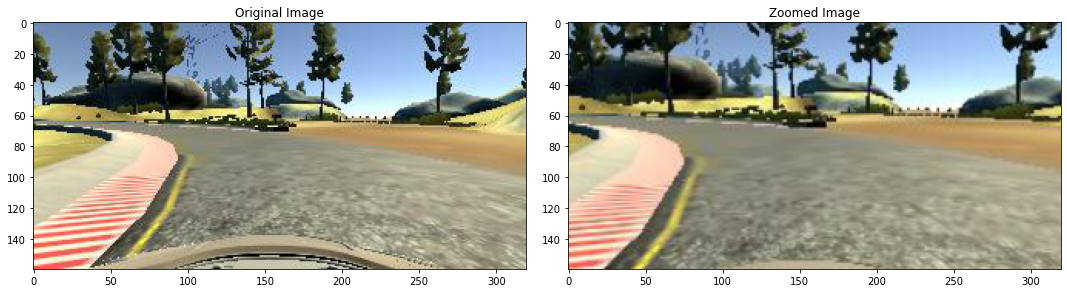

In [16]:
image = image_paths[random.randint(0,700)]
original_image = mping.imread(image)
zoomed_image = zoom(original_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")

axes[1].imshow(zoomed_image)
axes[1].set_title("Zoomed Image")
plt.show()

In [17]:
# PAN

def pan(image) :
  pan =iaa.Affine(translate_percent={'x':(-0.1,0.1),"y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

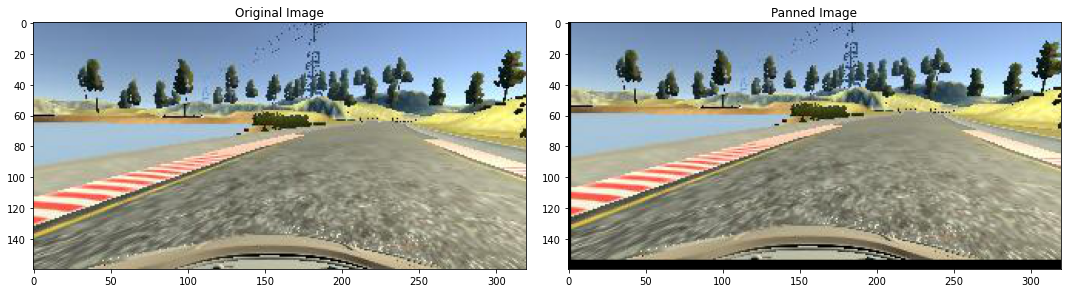

In [18]:
image = image_paths[random.randint(0,700)]
original_image = mping.imread(image)
panned_image = pan(original_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")

axes[1].imshow(panned_image)
axes[1].set_title("Panned Image")
plt.show()

In [19]:
# Change Image Brightness

def img_random_brightness(image) :
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

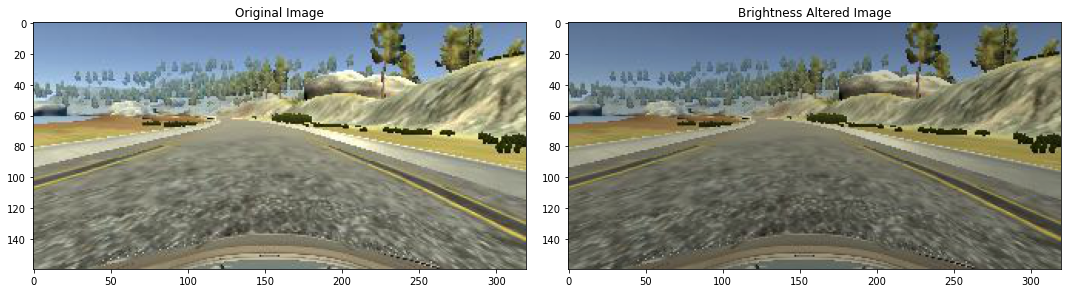

In [20]:
image = image_paths[random.randint(0,700)]
original_image = mping.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")

axes[1].imshow(brightness_altered_image)
axes[1].set_title("Brightness Altered Image")
plt.show()

In [21]:
# Image Horizontal Flip

def img_random_flip(image,steering_angle) :
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

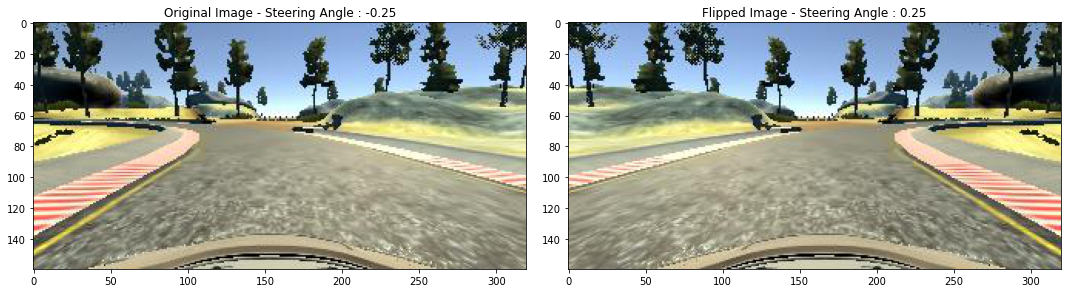

In [22]:
random_index = random.randint(0,700)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mping.imread(image)
flipped_image,flipped_steering_angle = img_random_flip(original_image,steering_angle)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image - " + "Steering Angle : " + str(steering_angle))

axes[1].imshow(flipped_image)
axes[1].set_title("Flipped Image - " + "Steering Angle : " + str(flipped_steering_angle))
plt.show()

In [23]:
# Random Augmentation

def random_augment(image,steering_angle) :
  image = mping.imread(image)
  if np.random.rand() < 0.5 : 
    image = pan(image)
  if np.random.rand() < 0.5 : 
    image = zoom(image)
  if np.random.rand() < 0.5 : 
    image = img_random_brightness(image)
  if np.random.rand() < 0.5 : 
    image,steering_angle = img_random_flip(image,steering_angle)
  
  return image, steering_angle

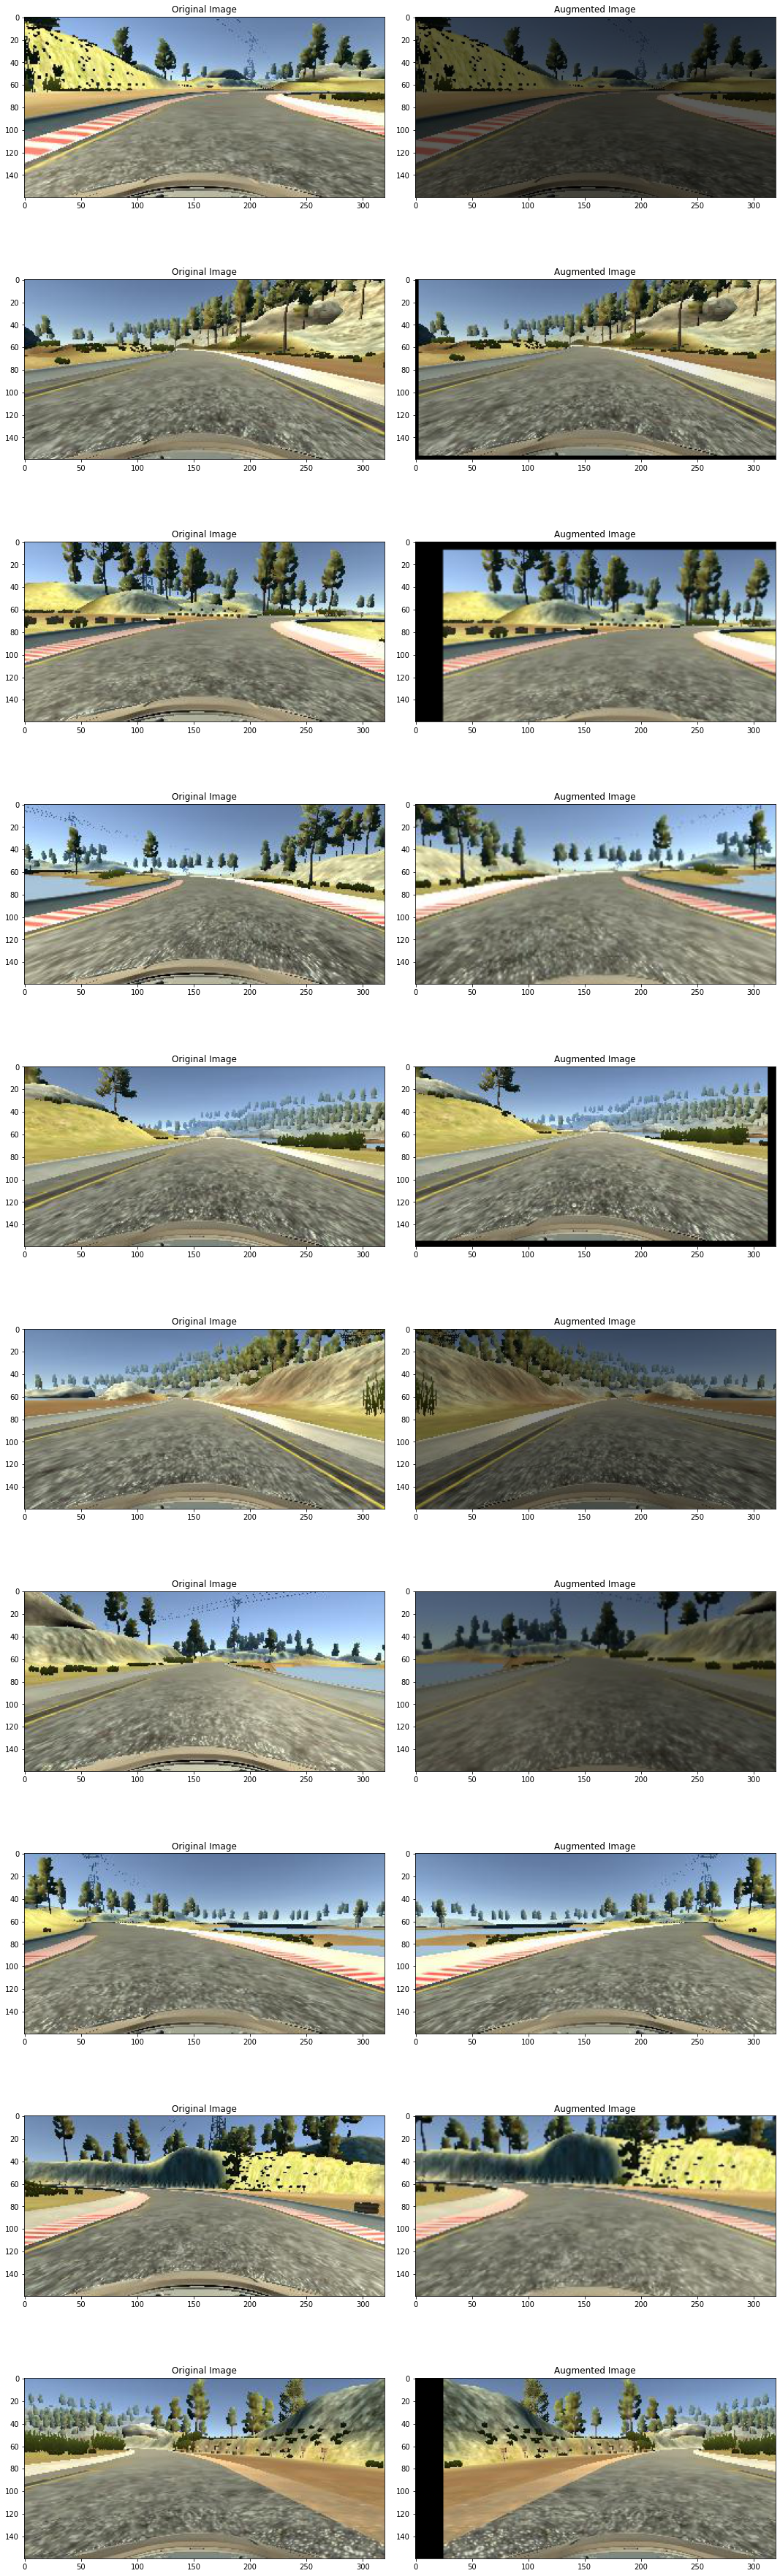

In [24]:
# Random Augmentation 예시

ncol = 2 
nrow = 10

fig,axes = plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10) :
  randnum = random.randint(0,len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mping.imread(random_image)
  augmented_image, steering = random_augment(random_image,random_steering)

  axes[i][0].imshow(original_image)
  axes[i][0].set_title("Original Image")

  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title("Augmented Image")

In [25]:
# Image preprocessing

def img_preprocessing(img) :
  img = img[60:135,:,:] # Crop
  img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV) # Change to YUV
  img = cv2.GaussianBlur(img,(3,3),0) # smoothing effect
  img = cv2.resize(img,(200,66)) # Resize
  img = img/255 # Intensity 조절
  return img

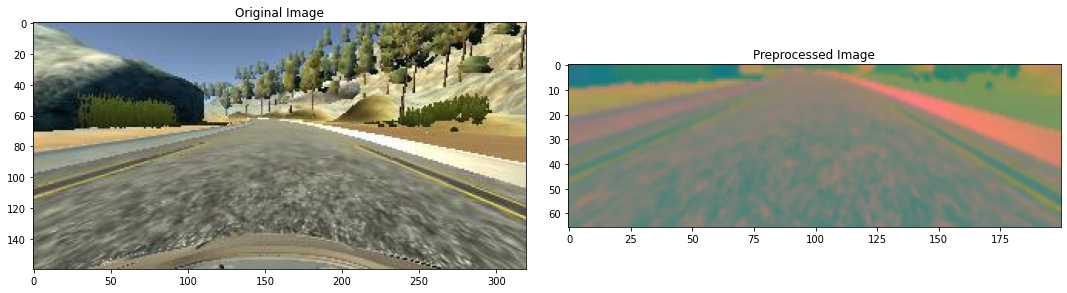

In [26]:
# 이미지 전처리 예시

image = image_paths[100]
original_image = mping.imread(image)
preprocessed_image = img_preprocessing(original_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("Preprocessed Image")
plt.show()

In [27]:
# Batch Generator 생성

def batch_generator(image_paths,steering_ang,batch_size,istraining) :
  while True :
    batch_img = []
    batch_steering = []

    for i in range(batch_size) :
      random_index = random.randint(0,len(image_paths)-1)

      if istraining :
        im, steering = random_augment(image_paths[random_index],steering_ang[random_index])
      else :
        im = mping.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img),np.asarray(batch_steering))

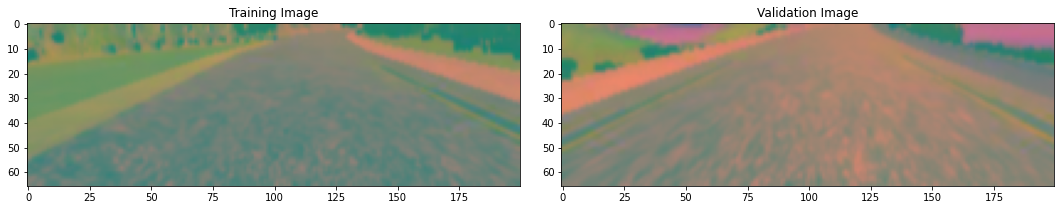

In [28]:
# Train / Validation Image 예시

X_train_gen,y_train_gen = next(batch_generator(X_train,y_train,1,1))
X_validation_gen, y_validation_gen = next(batch_generator(X_validation,y_validation,1,1))

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(X_train_gen[0])
axes[0].set_title("Training Image")

axes[1].imshow(X_validation_gen[0])
axes[1].set_title("Validation Image")
plt.show()

In [29]:
# Nvidia Model 적용

def nvidia_model() :
  model = Sequential()
  model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2),input_shape=(66,200,3),activation='relu'))
  model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2),activation='relu'))
  model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2),activation='relu'))
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100,activation='relu'))
  # model.add(Dropout(0.1))

  model.add(Dense(50,activation='relu'))
  # model.add(Dropout(0.2))

  model.add(Dense(10,activation='relu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(1))

  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
  return model


In [30]:
model = nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [31]:
history = model.fit_generator(
    batch_generator(X_train,y_train,100,1)
    ,steps_per_epoch=300,epochs=8
    ,validation_data=batch_generator(X_validation,y_validation,100,0)
    ,validation_steps=200
    ,verbose=1
    ,shuffle=1
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
300/300 [==============================] - 364s 1s/step - loss: 0.0890 - mse: 0.0890 - mae: 0.2245 - val_loss: 0.0358 - val_mse: 0.0358 - val_mae: 0.1523
Epoch 2/7
300/300 [==============================] - 360s 1s/step - loss: 0.0492 - mse: 0.0492 - mae: 0.1701 - val_loss: 0.0357 - val_mse: 0.0357 - val_mae: 0.1527
Epoch 3/7
300/300 [==============================] - 361s 1s/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1619 - val_loss: 0.0365 - val_mse: 0.0365 - val_mae: 0.1538
Epoch 4/7
300/300 [==============================] - 359s 1s/step - loss: 0.0416 - mse: 0.0416 - mae: 0.1590 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.1557
Epoch 5/7
300/300 [==============================] - 358s 1s/step - loss: 0.0394 - mse: 0.0394 - mae: 0.1553 - val_loss: 0.0338 - val_mse: 0.0338 - val_mae: 0.1492
Epoch 6/7
300/300 [==============================] - 360s 1s/step - loss: 0.0392 - mse: 0.0392 - mae: 0.1540 - val_loss: 0.0345 - val_mse: 0.0345 - val_mae: 0.1526
Epoch 7/7
300/30

## 1st Trial (이미지 증강 미포함)

In [ ]:
# first_trial_loss = history.history['loss']
# first_trial_val_loss = history.history['val_loss']


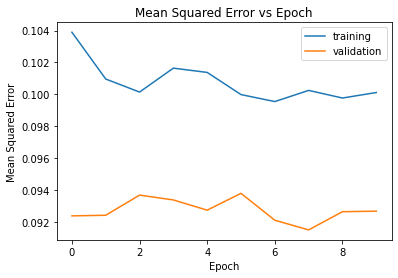

In [734]:

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['training','validation'])
# plt.title("Mean Squared Error vs Epoch")
# plt.xlabel("Epoch")
# plt.ylabel("Mean Squared Error")
# plt.show()

## 2nd Trial (이미지 증강 포함)

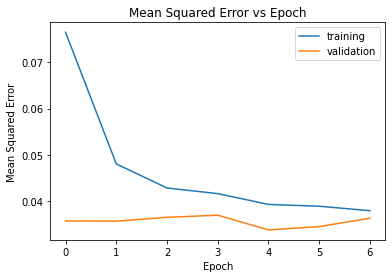

In [34]:
second_trial_loss = history.history['loss']
second_trial_val_loss = history.history['val_loss']
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title("Mean Squared Error vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.show()

In [32]:
model.save("second_trial.h5")

In [33]:
from google.colab import files
files.download('second_trial.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

* 다양한 이미지 증강 기법들을 활용했을 때 모델 성능이 크게 개선되었습니다.

* 하지만 시뮬레이션을 돌려본 결과 완주를 하는 경우도 있었고 차선을 이탈하는 경우도 있었습니다.
  * 또한 학습한 모델을 가지고 새로운 맵에서 시뮬레이션을 돌렸을 때 자율주행이 제대로 이루어지지 않았다는 점을 보면 일반화된 모델이 만들어지지 않았음을 의미합니다.

* 다양한 딥러닝 모델에서도 적용시켜보고 성능 비교를 해보면서 하나씩 개선해나갈 필요가 있습니다. 